In [22]:
import pandas as pd

df = pd.read_csv("../Data/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [23]:
print(df.columns)
df.info()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='str')
<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.6 MB


Från `df.info()`ser vi att variabeln total_bedrooms innehåller saknade värden. Eftersom bortfallet är litet ersätts dessa med medianvärdet, som är mer robust mot extremvärden än medelvärdet.

In [24]:
num=df["total_bedrooms"].isna().sum() # kontrollerar hur många saknade värden finns 
print(f" number av saknade vädren i total_bedrooms är {num}")
# fill saknade värden med median värde
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())
num=df["total_bedrooms"].isna().sum()
num


 number av saknade vädren i total_bedrooms är 207


np.int64(0)

In [25]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Variabeln `ocean_proximity` är en kategorisk variabel. Med hjälp av `value_counts()` analyseras vilka kategorier som finns samt hur många observationer som tillhör varje kategori. Detta ger en överblick över fördelningen mellan grupperna.

In [26]:
df["ocean_proximity"].value_counts()  # Kontrollera kategorier som finns 
                                      # i variabeln och hur många värden på varje kategori

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

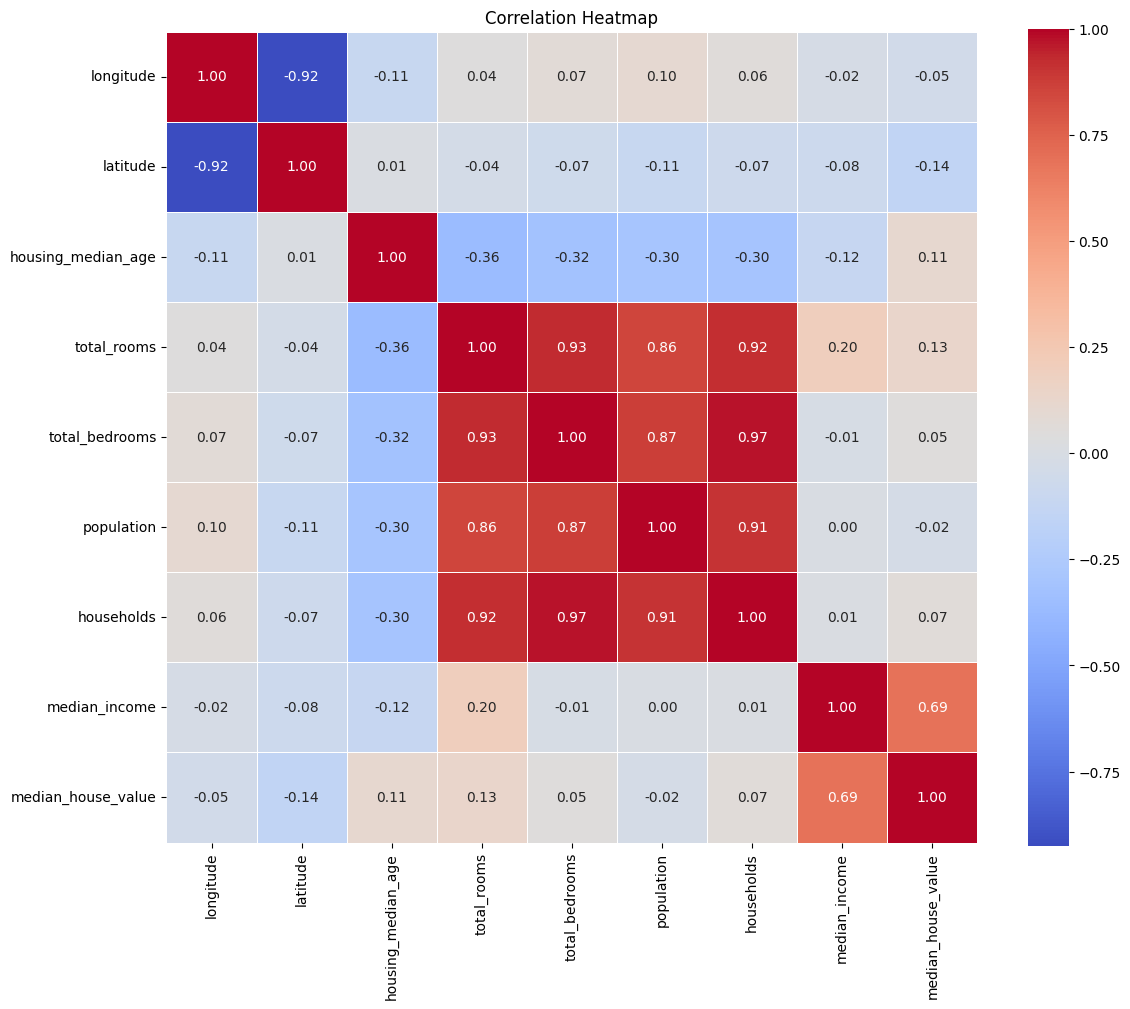

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ta bara numeriska kolumner
corr = df.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap")
plt.tight_layout()


## **Korrelationsanalys och val av variabler**

Heatmapen visar att `median_income` har starkast positiv linjär korrelation med `median_house_value` (0.69). Övriga numeriska variabler uppvisar svagare samband med responsvariabeln.

Vidare visar heatmapen att flera storleksrelaterade variabler (`total_rooms`, `total_bedrooms`, `population`, `households`) är starkt korrelerade med varandra, vilket indikerar multikollinaritet. För att undvika instabila skattningar väljs därför endast ett begränsat antal numeriska variabler.

Den kategoriska variabeln `ocean_proximity` inkluderas trots att den inte kan analyseras i heatmapen, eftersom den representerar en strukturell geografisk egenskap (närhet till havet) som rimligen påverkar bostadspriser. Valet baseras alltså på teoretisk och domänspecifik motivering snarare än enbart korrelationsanalys.

Den testade modellen inkluderar därför:

- `median_income`
- `housing_median_age`
- `population`
- `ocean_proximity` (dummy-variabler)


**Creates scatter plots showing how each housing numeric feature relates to house value**


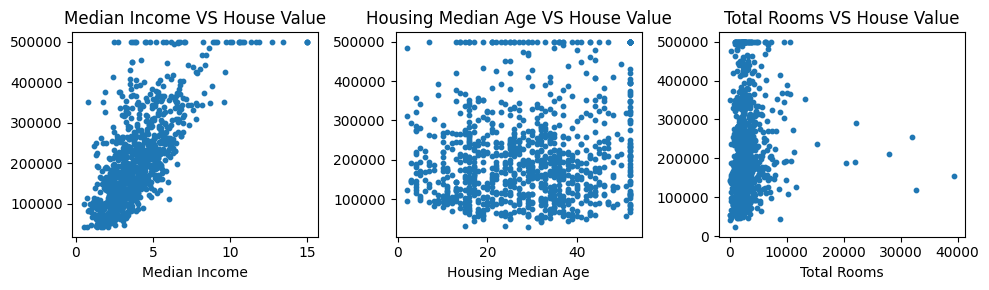

In [28]:
import numpy as np

y = df['median_house_value'].to_numpy()
X_num = df[['median_income', 'housing_median_age', 'total_rooms']].to_numpy()
features = ['median_income', 'housing_median_age', 'total_rooms']

fig, ax = plt.subplots(1, X_num.shape[1], figsize=(10,3), dpi=100)

for i in range(X_num.shape[1]):
    idx = np.random.choice(len(y), 1000, replace=False)
    ax[i].scatter(X_num[idx, i], y[idx], s=10)
    ax[i].set(xlabel=features[i].replace("_", " ").title(), 
            title=f"{features[i].replace("_", " ").title()} VS House Value")

plt.tight_layout()


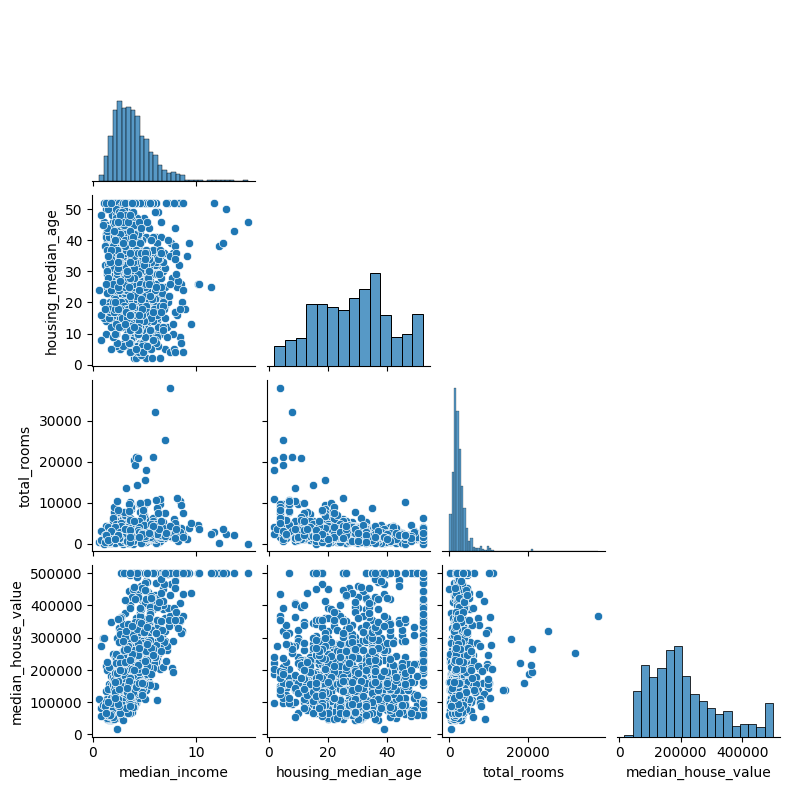

In [29]:
import seaborn as sns

cols = ['median_income', 'housing_median_age', 'total_rooms', 'median_house_value']
df_s = df[cols].sample(1000, random_state=42)
ax = sns.pairplot(df_s,corner=True, height=2)



### **Pairplot**

Pairploten ger en översikt av de parvisa relationerna mellan de valda variablerna i bostadsdatasetet.

Resultatet visar ett tydligt och ungefär linjärt positivt samband mellan **median_income** och **median_house_value**, vilket indikerar att högre inkomstnivåer är starkt associerade med högre huspriser. Sambanden mellan **housing_median_age**, och husvärde är svagare och uppvisar större spridning, vilket tyder på begränsad förklaringskraft i relation till målvariabeln.

Histogrammen längs diagonalen visar att flera variabler är snedfördelade, särskilt **total_rooms** och **median_house_value**



In [30]:
df_s.corr()

,median_income,housing_median_age,total_rooms,median_house_value
median_income,1.000000,-0.100599,0.203003,0.701940
housing_median_age,-0.100599,1.000000,-0.356720,0.122964
total_rooms,0.203003,-0.356720,1.000000,0.128153
median_house_value,0.701940,0.122964,0.128153,1.000000


För att inkludera den kategoriska variabeln i regressionsmodellen omvandlas den till dummyvariabler (one-hot encoding), där varje kategori representeras av en binär variabel.

In [31]:
X_num = df[['median_income', 'housing_median_age', 'total_rooms']]
X_ocean = pd.get_dummies(df["ocean_proximity"], drop_first=True)
X = pd.concat([X_num, X_ocean], axis=1)
feature_names = X.columns.tolist()
display(X.head())
X=X.to_numpy()

,median_income,housing_median_age,total_rooms,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,8.3252,41.0,880.0,False,False,True,False
1,8.3014,21.0,7099.0,False,False,True,False
2,7.2574,52.0,1467.0,False,False,True,False
3,5.6431,52.0,1274.0,False,False,True,False
4,3.8462,52.0,1627.0,False,False,True,False


Vi kombinerar samtliga variabler till en gemensam designmatris **𝑋**, som slutligen konverteras till NumPy-format för användning i den linjära regressionsmodellen.

In [32]:
from Linear_regression import LinearRegression  # ändra om din fil heter något annat

# Fit modellen
model = LinearRegression(add_intercept=True)
print(model)
model.fit(X, y)
print(model)

# Koefficienter (b)
b = model.beta_
print("=== Linear Regression (G) ===\n")

print("Koefficienter (beta):")
print(f"Intercept (b0): {b[0]:.6f}")
for i, name in enumerate(feature_names, start=1):
    print(f"  {name} (b{i}): {b[i]:.6f}")

print("\nDatastorlek:")
print(f"  n (antal observationer): {model.n_}")
print(f"  d (antal features):      {model.d_}")

print("\nFel- och spridningsmått:")
print(f"  SSE:                     {model.sse():.6f}")
print(f"  Varians:       {model.sample_variance():.6f}")
print(f"  Standardavvikelse :   {model.standard_deviation():.6f}")
print(f"  RMSE:                    {model.rmse():.6f}")

LinearRegression(unfitted)
Y = 38570.3377 + 37562.9245*X1 + 1143.6255*X2 + 3.4671*X3 + -71484.8091*X4 + 184832.2257*X5 + 12101.5890*X6 + 17874.4663*X7
=== Linear Regression (G) ===

Koefficienter (beta):
Intercept (b0): 38570.337745
  median_income (b1): 37562.924518
  housing_median_age (b2): 1143.625505
  total_rooms (b3): 3.467086
  INLAND (b4): -71484.809050
  ISLAND (b5): 184832.225674
  NEAR BAY (b6): 12101.588963
  NEAR OCEAN (b7): 17874.466261

Datastorlek:
  n (antal observationer): 20640
  d (antal features):      7

Fel- och spridningsmått:
  SSE:                     109790147056864.421875
  Varians:       5321352610.355972
  Standardavvikelse :   72947.601814
  RMSE:                    72933.463311


Text(0.5, 1.0, 'Predicted vs Actual')

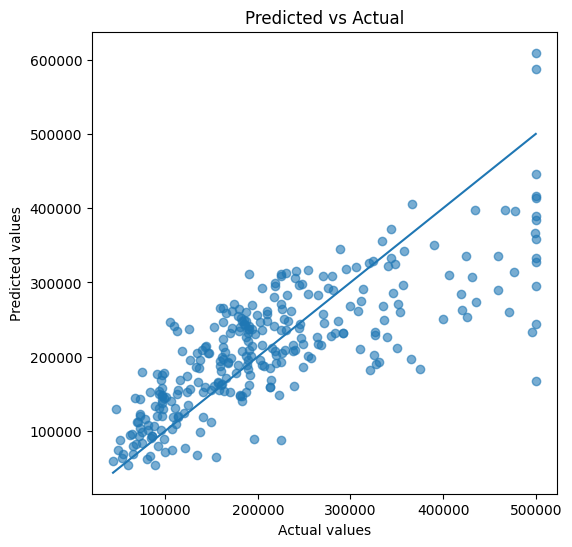

In [33]:
# Slumpa 300 index
np.random.seed(42)
idx= np.random.choice(X.shape[0], 300, replace=False)
# Ta subset
X_sample = X[idx]
y_sample = y[idx]
# Hämta beta 
b = model.beta_
# Lägg till intercept om modellen använder det if model.add_intercept:
X_sample = np.column_stack([np.ones(X_sample.shape[0]), X_sample])
y_pred = X_sample @ b

plt.figure(figsize=(6,6))
plt.scatter(y_sample, y_pred, alpha=0.6)

line = np.linspace(min(y_sample), max(y_sample), 100)
plt.plot(line, line)

plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Predicted vs Actual")


En scatterplot mellan faktiska och predikterade värden används för att bedöma modellens träffsäkerhet. Punkter nära diagonalen indikerar god anpassning.

In [34]:
# Hämta feature-namn i samma ordning som X användes
X_num = ["median_income", "housing_median_age", "total_rooms"]
X_ocean = pd.get_dummies(df["ocean_proximity"], drop_first=True)

feature_names = ["Intercept"] + X_num + list(X_ocean.columns)

for name, coef in zip(feature_names, model.beta_):
    print(f"{name:25s}: {coef:.2f}")


Intercept                : 38570.34
median_income            : 37562.92
housing_median_age       : 1143.63
total_rooms              : 3.47
INLAND                   : -71484.81
ISLAND                   : 184832.23
NEAR BAY                 : 12101.59
NEAR OCEAN               : 17874.47


np.float64(-1.5705559482119342e-07)

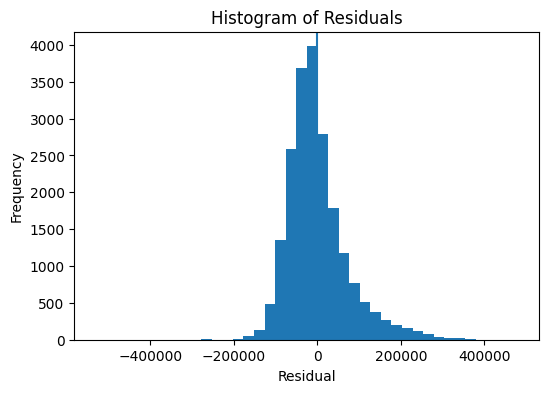

In [35]:
residuals = y - model.predict(X)

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.axvline(0)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")

np.mean(residuals)



- Residualerna har medelvärde ≈ 0
- Modellen har inget systematiskt bias
-  OLS-lösningen fungerar korrekt

### Effekt av ocean_proximity

Dummyvariablerna för `ocean_proximity` visar tydliga prisskillnader mellan olika geografiska lägen jämfört med referenskategorin.

`INLAND` har en stark negativ effekt (−71 485), medan `ISLAND` har en mycket stark positiv effekt (+184 832). Även `NEAR BAY` (+12 102) och `NEAR OCEAN` (+17 874) visar positiva prispåslag.

Detta bekräftar att geografiskt läge har en betydande påverkan på bostadspriserna .

### Resultat av linjär regression (G)

Modellen bygger på 20 640 observationer och tre förklarande variabler: `median_income`, `housing_median_age` och `total_rooms`,samt dummyvariabler för `ocean_proximity`, utöver ett intercept..

`median_income` har den tydligaste effekten och visar ett starkt positivt samband med bostadspriset. `housing_median_age` har en mindre positiv effekt, medan `total_rooms` bidrar marginellt till modellen.Dummyvariablerna indikerar att geografisk närhet till havet har betydelse för bostadspriserna relativt referenskategorin

RMSE är cirka 73 000 USD, vilket innebär att modellens prediktioner i genomsnitt avviker med ungefär 73 000 USD från de observerade värdena.

Sammanfattningsvis fångar modellen sambandet mellan inkomst och bostadspriser, men en betydande del av variationen i bostadsvärden förklaras inte av modellen.


## **VG del**

In [36]:
F, p, reject = model.f_test(alpha=0.05)
print(f"F-statistic: {F:.4f}")
print(f"p-value: {p:.3e}")
print("Significant:", reject)


F-statistic: 4430.7165
p-value: 0.000e+00
Significant: True


F-testet visar att modellen är statistiskt signifikant (F = 7265.81, p < 0.001), vilket innebär att minst en av förklarande variablerna bidrar till att förklara bostadsvärdet

In [37]:
r2 = model.r_squared()
print(f"R: {r2:.4f}")
print(f"Model explains {r2*100:.2f}% of the variance in y.")


R: 0.6005
Model explains 60.05% of the variance in y.


Resultatet visar att modellen förklarar drygt hälften av variationen i bostadsvärdena. Detta indikerar att modellen har relativt god förklaringsförmåga, men att ytterligare variabler skulle kunna förbättra precisionen.

In [38]:
results = []

for i in range(model._X.shape[1]):
    results.append(model.parameter_test(i))

df_results = pd.DataFrame(results)

df_results

,i,beta,se,t,p,significant
0,0,38570.337745,2249.877576,17.143305,2.002948e-65,True
1,1,37562.924518,283.812340,132.351273,0.000000e+00,True
2,2,1143.625505,46.081164,24.817635,5.321677e-134,True
3,3,3.467086,0.253696,13.666325,2.466955e-42,True
4,4,-71484.809050,1243.977797,-57.464699,0.000000e+00,True
5,5,184832.225674,32638.309974,5.663045,1.506884e-08,True
6,6,12101.588963,1745.959565,6.931197,4.296068e-12,True
7,7,17874.466261,1608.847513,11.110106,1.350427e-28,True


Eftersom alla p-värden är små förkastar vi nollhypotesen. Det betyder att varje variabel bidrar statistiskt signifikant till modellen.
